# Optimizing EKG Circuit

In [81]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

In [82]:
ohm = UNITS.ohm
farad = UNITS.farad
volt = UNITS.volt
Hz = UNITS.Hz
second = UNITS.second;

In [143]:
params1 = Params(
    R = 4.9e3,   # ohm
    C = 1e-6,  # farad
    A = 5,      # volt
    f = 40,   # Hz
    vin = 0
)

,values
R,4900.000000
C,0.000001
A,5.000000
f,40.000000
vin,0.000000


In [155]:
def make_system(params):
    """Makes a System object for the given conditions.
    
    params: Params object
    
    returns: System object
    """
    unpack(params)
    
    init = State(V_out = 0)
    omega = 2 * np.pi * f
    tau = R * C
    cutoff = 1 / R / C / 2 / np.pi
    t_end = 4 / f
    ts = linspace(0, t_end, 401)
    
    return System(R=R, C=C, A=A, f=f,
                  init=init, t_end=t_end, ts=ts,
                  omega=omega, tau=tau, cutoff=cutoff, vin=vin)

In [156]:
system1 = make_system_init(params1);

In [159]:
def slope_func_init(state, t, system):
    """Makes a slope function to update the state.
    
    state: State(V_out)
    t: time
    system: System Object
    
    returns: State(V_out)
    """
    vout = state
    
    unpack(system)
    
    vin = A * np.cos(2 * pi * f * t)
    
    dvoutdt = (vin - vout) / (R * C)
    
    return dvoutdt

In [160]:
results1, details1 = run_ode_solver(system1, slope_func_init, t_eval=system1.ts)

In [161]:
def plot_results(results):
    xs = results.V_out.index
    ys = results.V_out.values

    t_end = get_last_label(results)
    if t_end < 10:
        xs *= 1000
        xlabel = 'Time (ms)'
    else:
        xlabel = 'Time (s)'
        
    plot(xs, ys)
    decorate(xlabel=xlabel,
             ylabel='$V_{out}$ (volt)',
             legend=False)

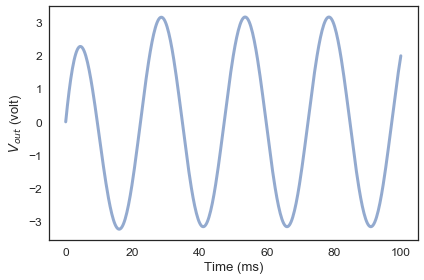

In [162]:
plot_results(results1)

In [170]:
#vin1 = interpolate(results1.V_out)

In [171]:
params2 = Params(
    R = 4.9e3,   # ohm
    C = 1e-6,  # farad
    vin = results1.V_out
)

,values
R,4900
C,1e-06
vin,0.00000 0.000000 0.00025 0.248538 0.0005...


In [172]:
system2 = make_system(params2)

,values
R,4900
C,1e-06
A,5
f,40
init,V_out 0 dtype: int64
t_end,0.1
ts,"[0.0, 0.00025, 0.0005, 0.00075, 0.001, 0.00125..."
omega,251.327
tau,0.0049
cutoff,32.4806


In [192]:
def slope_func_2(state, t, system):
    """Makes a slope function to update the state.
    
    state: State(V_out)
    t: time
    system: System Object
    
    returns: State(V_out)
    """
    vout = state
    
    #unpack(system)
    
    vin = interpolate(system.vin)
    
    dvoutdt = (vin(t) - vout) / (system.R * system.C)
    
    return dvoutdt

In [193]:
results2, details2 = run_ode_solver(system2, slope_func_2, t_eval=system2.ts)

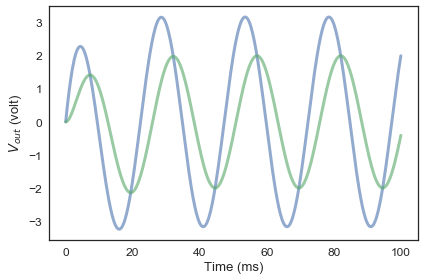

In [197]:
plot_results(results1)
plot_results(results2)

Help on function run_ode_solver in module modsim:

run_ode_solver(system, slope_func, **options)
    Computes a numerical solution to a differential equation.
    
    `system` must contain `init` with initial conditions,
    `t_0` with the start time, and `t_end` with the end time.
    
    It can contain any other parameters required by the slope function.
    
    `options` can be any legal options of `scipy.integrate.solve_ivp`
    
    system: System object
    slope_func: function that computes slopes
    
    returns: TimeFrame

